<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03%20Machine%20Learning/notebooks/05-Pipelines-MCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multicolinealidad, Regresión Polinomial y Pipelines

* 🔽 Esta sección no forma parte del proceso usual de Machine Learning. Es una exploración didáctica de algún aspecto del funcionamiento del algoritmo.
* ⚡ Esta sección incluye técnicas más avanzadas destinadas a optimizar o profundizar en el uso de los algoritmos.
* ⭕ Esta sección contiene un ejercicio o práctica a realizar. Aún si no se establece una fecha de entrega, es muy recomendable realizarla para practicar conceptos clave de cada tema.


## Ejemplo 1: Multicolinealidad

**Impacto de la Multicolinealidad**  
* **Para predicción**: La multicolinealidad no es un problema (mientras no sea perfecta).  
* **Para interpretación**: Es un problema grave (coeficientes no confiables).  
- **Soluciones**:  
  - Regularización (Ridge/Lasso).  
  - Eliminación de variables redundantes.  
  - Transformaciones (PCA).  

**¿Cómo detectarla?**  
- **Matriz de correlación** (valores > 0.8 o < -0.8).  
- **VIF (Factor de Inflación de Varianza)** > 5 o 10. [Implementación en statsmodel](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)
- **Análisis de componentes principales (PCA)** (autovalores cercanos a 0).  

Usaremos el dataset de precios de casas incluido en colab

| Columna           | Descripción                                                                 | Rango en el Dataset            | Tipo de dato |
|-------------------|-----------------------------------------------------------------------------|--------------------------------|--------------|
| longitude         | Medida de qué tan al oeste está una casa (valores más altos: más este) | -124.3 a -114.3               | float64      |
| latitude          | Medida de qué tan al norte está una casa (valores más altos: más norte)     | 32.5 a 42.5                   | float64      |
| housingMedianAge  | Edad mediana de las casas en un bloque (número bajo = edificio nuevo)        | 1.0 a 52.0                    | float64      |
| totalRooms        | Número total de habitaciones en un bloque                                    | 2.0 a 37,937.0                | float64      |
| totalBedrooms     | Número total de dormitorios en un bloque                                     | 1.0 a 6,445.0                 | float64      |
| population        | Número total de personas en un bloque                                        | 3.0 a 35,682.0                | float64      |
| households        | Número total de hogares (grupos de personas en una unidad de vivienda)       | 1.0 a 6,082.0                 | float64      |
| medianIncome      | Ingreso mediano por hogar en un bloque (en decenas de miles de USD)          | 0.5 a 15.0                    | float64      |
| medianHouseValue  | Valor mediano de las casas en un bloque (en USD)                             | 14,999.0 a 500,001.0          | float64      |

In [ ]:
import pandas as pd

path = '/content/sample_data/california_housing_train.csv'
df = pd.read_csv(path)
df

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df['longitude'],df['latitude'],c=df['median_house_value'],cmap='jet')
plt.colorbar()
plt.show()

Una manera de visualizar la multicolinealidad es ver las **correlaciones entre variables predictoras**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corrs = df.corr()

plt.figure(figsize=(8,8))
sns.heatmap(corrs,annot=True)
plt.show()

In [ ]:
from seaborn import pairplot

plt.figure(figsize=(10,10))
pairplot(df)
plt.show()

Entrenemos un modelo de Regresión Lineal para este conjunto de datos

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# ---- Si escogemos todas las variables ----
X = df.iloc[:,:-1].values
y = df['median_house_value'].values

# ---- Si eliminamos algunas variables ----
# cols = df.iloc[:,:-1].columns.to_list()
# cols_to_remove = ['total_bedrooms','households']
# new_cols = [col for col in cols if col not in cols_to_remove]
# X = df[new_cols].values
# y = df['median_house_value'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=57)

lr = LinearRegression()
lr.fit(X_train,y_train)
print(f"Score en el conjunto de entrenamiento: {lr.score(X_train,y_train)}") # coefficient of determination of the prediction

y_pred = lr.predict(X_test)
print(f"MAE en el conjunto de prueba {mean_absolute_error(y_test,y_pred)}")
print(f"MAPE en el conjunto de prueba {mean_absolute_percentage_error(y_test,y_pred)}")

🔷 Como podemos confirmar, no es tanto que afecte al rendimiento. Su efecto se puede notar más en la interpretabilidad de los coeficientes.

🔽 **Para observar el efecto de la multicolinealidad realicemos el siguiente experimento**. En cada corrida resampleamos aleatoriamente (con reemplazo) las muestras de entrenamiento y con este nuevo conjunto, hacemos un entrenamiento de regresión lineal. Luego guardamos los coeficientes del modelo y visualizamos la distribución de estos.

In [ ]:
#@title Ejemplo Bootstrapping
from IPython.display import display, HTML

!gdown 1Ki25YePoHOkUItsoXhnFtVvN1cDffd5U

# Ruta relativa donde está tu archivo en Drive
file_path = 'bootstrapping_animation.html'

with open(file_path, 'r') as f:
    html_content = f.read()

display(HTML(html_content))

[`resample` de scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html)

In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pandas as pd

n_iterations = 100  # Número de remuestreos
coefficients = []

cols = df.iloc[:,:-1].columns.to_list()
X = df[cols].values
y = df['median_house_value'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=57)

# ---- En este caso es importante re-escalar para poder comparar entre desviaciones
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# --------------------------------------------------

for _ in range(n_iterations):
    X_resampled, y_resampled = resample(X_train, y_train,
                                        random_state=np.random.randint(100)) # Bootstraping
    # Entrenar modelo
    model = LinearRegression()
    model.fit(X_resampled, y_resampled) # Entrenamos el modelo
    coefficients.append(model.coef_) # Guardamos los coeficimientos

coef_df = pd.DataFrame(coefficients, columns=cols) # Convertimos a dataframe
coef_df.describe().round(2)  # Media, desviación estándar, percentiles

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(coef_df.iloc[:,2:].values, tick_labels=cols[2:])
plt.xticks(rotation=45)
plt.title("Variabilidad de los Coeficientes (Bootstrap)")
plt.ylabel("Valor del Coeficiente")
plt.show()

🔷 Podemos ver que la desviación es grande en las features con multicolinealidad, además de los cambios de signo.

## Ejemplo 2: Regresión Polinomial

Usaremos el siguiente dataset de datos de peces. Hay un total de 159 filas (muestras de entrenamiento) y 7 columnas en el conjunto de datos.

Los detalles de cada columna son los siguientes

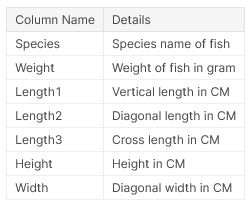

* Las variables independientes son "Especie", "Longitud1", "Longitud2", "Longitud3", "Altura" y "Anchura".
* La variable dependiente es "Peso".

Tenemos que **estimar el peso del pez basándonos en sus mediciones**.

In [ ]:
import pandas as pd

url = 'https://github.com/DCDPUAEM/DCDP/raw/main/03%20Machine%20Learning/data/fishes.csv'
df = pd.read_csv(url)
df

Descripción de Features:

- **Species**: Especie del pez (ej. Bream, Smelt).
- **Weight**: Peso del pez en gramos.
- **Length1**: Longitud 1 (vertical) en cm.
- **Length2**: Longitud 2 (diagonal) en cm.
- **Length3**: Longitud 3 (horizontal) en cm.
- **Height**: Altura del pez en cm.
- **Width**: Ancho del pez en cm.


⭕ Práctica

Construye un modelo de Regresión Lineal (Polinomial) para predecir el peso de un pez en función de las variables predictoras.

**Preprocesamiento**

* Verifica si hay valores faltantes.
* Verifica la correlación entre variables usando el método [corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) del dataframe. Considera eliminar las variables con correlación para evitar la multicolinealidad. **Prueba con ambas opciones:** dejar todas las variables o no.
* Explora la relación entre pares de variables usando [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) de seaborn. Esto te puede ayudar a visualizar qué variables están más correlacionadas con la variable a predecir, además, de dar una idea de cómo es la relación.
* Verifica el rango de las variables (no solamente el rango, sino también el máximo y mínimo). **Prueba con diferentes tipos de re-escalamiento y sin re-escalamiento**.
* Usar PolinomialFeatures en función de tus observaciones del punto anterior. **Prueba con diferentes grados del polinomio.**
* Usa la codificación one-hot para la(s) variable(s) categórica(s). **Prueba ambas opciones: incluye esta variable o no.**

**Regresión Lineal**

Entrena un modelo de RL separando el 75% para entrenamiento y reporta la métrica de rendimiento MAE y MAPE. **Además, prueba usando regularización**



**Pasos a realizar**

1.   Primero prueba con el siguiente modelo: Regresión Polinomial de grado 2 con todas las variables numéricas, sin re-escalamiento, sin la variable categórica (intenta implementarlo como pipeline).
2.  El mismo modelo anterior pero implementado como pipeline, en caso de que no lo hayas hecho así en el punto anterior.
3.  Prueba diferentes modelos considerando las combinaciones de técnicas descritas arriba. Reporta el modelo que haya logrado el RMSE más bajo.



**Responde las siguientes preguntas:**

* ¿Qué efecto tiene dejar todas las variables contra quitar variables correlacionadas?
* ¿Cuál es el grado que mejor funcionó?

Separamos la variable dependiente y target.

In [ ]:
y = df['Weight'].values
print(y.shape)

X_df = df.drop(columns='Weight')
print(X_df.shape)

### Análisis Exploratorio

In [ ]:
X_df.iloc[:,1:].corr()

In [ ]:
from seaborn import pairplot
import matplotlib.pyplot as plt

pairplot(X_df.iloc[:,1:])
plt.show()

🔷 ¿Cuáles variables estan correlacionadas?

Quitamos las variables correlacionadas: Nos quedamos solamente con `Lenght1` de las tres longitudes.



In [ ]:
X_df.columns.to_list()

In [ ]:
# columns_to_keep = ['Species', 'Length1', 'Length2', 'Length3', 'Height', 'Width']
columns_to_keep = ['Species', 'Length1', 'Height', 'Width']
X_df = X_df[columns_to_keep]
X_df

Veamos las variables categóricas

In [ ]:
X_df['Species'].unique()

In [ ]:
from seaborn import countplot
import matplotlib.pyplot as plt

countplot(X_df['Species'])
plt.show()

Realizamos la codificación *one-hot* cuidando de quitar una de las columnas finales para no introducir una variable colineal.

In [ ]:
X_df = pd.get_dummies(X_df,dtype='int',drop_first=True)
X_df

Usamos sólo las variables categóricas

In [ ]:
X = X_df.iloc[:,3:]
print(X.shape)

Usamos todas las variables

In [ ]:
X = X_df.values
print(X.shape)

Usamos sólo las variables de mediciones

In [ ]:
X = X_df.iloc[:,:3].values
print(X.shape)

Entrenemos el modelo de regresión lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=573,
                                                    train_size=0.75)

lr = LinearRegression()
lr.fit(X_train,y_train)

print(f"Score en el conjunto de entrenamiento: {lr.score(X_train,y_train)}") # coefficient of determination of the prediction

y_pred = lr.predict(X_test)
print(f"MAE en el conjunto de prueba {mean_absolute_error(y_test,y_pred)}")
print(f"MAPE en el conjunto de prueba {mean_absolute_percentage_error(y_test,y_pred)}")

🔷 El rendimiento es muy malo, aún cuando R^2 es alto

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

#----- IMPORTA LO NECESARIO ----

#-------------------------------

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=573,
                                                    train_size=0.75)

#--- INSERTA AQUÍ EL RE-ESCALAMIENTO ---


X_train_scl = ...
X_test_scl = ...

#---------------------------------------

lr = LinearRegression()
lr.fit(X_train_scl,y_train)

print(f"Score en el conjunto de entrenamiento: {lr.score(X_train_scl,y_train)}") # coefficient of determination of the prediction

y_pred = lr.predict(X_test_scl)
print(f"MAE en el conjunto de prueba {mean_absolute_error(y_test,y_pred)}")
print(f"MAPE en el conjunto de prueba {mean_absolute_percentage_error(y_test,y_pred)}")

🔷 ¿Y si probamos regularización Ridge, o similar? ¿junto con selección de features?

## Ejemplo 2b: Pipelines

Un **pipeline** en scikit-learn es una secuencia de transformaciones y un estimador final que se aplican a los datos de manera automatizada. Sirve para encadenar múltiples pasos de preprocesamiento (como escalado, imputación, etc.) y un modelo de machine learning en un único objeto, garantizando consistencia y evitando fugas de datos durante la validación cruzada.  

**Ventajas:**  
- **Simplifica el código:** Combina todos los pasos en un único objeto.  
- **Previene data leakage:** Asegura que las transformaciones se apliquen correctamente durante la validación cruzada.  
- **Facilita el mantenimiento:** Cambios en el flujo son más fáciles de implementar.  
- **Reproducibilidad:** Estandariza el proceso de entrenamiento y predicción.  
- **Optimización integrada:** Permite usar `GridSearchCV` o `RandomizedSearchCV` en todos los pasos del pipeline.  

Documentación: [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).  

![ML proceso](https://drive.google.com/uc?id=1S9KVyZbkiciIEeC7cLi-epa62gfFM0pi)

Encapsulando todo en pipelines:

![ML pipeline](https://drive.google.com/uc?id=1vaB4LfliQeomlbbiVua_cQGYnioQHYfY)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.25,
                                                    random_state=57)

pl = Pipeline([
               ('scl',StandardScaler()),
               ('pf',PolynomialFeatures(degree=2,include_bias=False)),
               ('lr',Ridge())])

pl.fit(X_train,y_train)
print(f"R2 en el conjunto de entrenamiento: {pl.score(X_train,y_train)}")

y_pred = pl.predict(X_test)
print(f"MAE en el conjunto de prueba {mean_absolute_error(y_test,y_pred)}")
print(f"MAPE en el conjunto de prueba {mean_absolute_percentage_error(y_test,y_pred)}")

🔷 Ha mejorado el rendimiento. Probemos varias combinaciones de hiperparámetros

## Un ejemplo de overfitting

El siguiente es un claro ejemplo de overfitting. Observa cómo la métrica de rendimiento es mucho mejor en el conjunto de entrenamiento que en el conjunto de prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=57)

pl = Pipeline([
               ('scl',StandardScaler()),
               ('pf',PolynomialFeatures(degree=10,include_bias=False)),
               ('lr',LinearRegression())])

pl.fit(X_train,y_train)
print(f"R2 en el conjunto de entrenamiento: {pl.score(X_train,y_train)}")

y_train_pred = pl.predict(X_train)
print(f"MSE en el conjunto de entrenamiento {mean_absolute_error(y_train,y_train_pred)}")
y_pred = pl.predict(X_test)
print(f"MSE en el conjunto de prueba {mean_absolute_error(y_test,y_pred)}")

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_train,y_train_pred,label='Entrenamiento')
plt.scatter(y_test,y_pred,label='Prueba')
plt.legend(loc='best')
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.show()

### Probando varias opciones

Probemos varios algoritmos para regresión:

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

estimadores = [Ridge(0.5),Ridge(2),Lasso(0.5),Lasso(2),ElasticNet(0.5),ElasticNet(2),LinearRegression()]

min_error = 10000

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=57)

for E in estimadores:
    pl = Pipeline([
                ('scl',StandardScaler()),
                ('pf',PolynomialFeatures(degree=2,include_bias=False)),
                ('lr',E)])
    pl.fit(X_train,y_train)
    y_pred = pl.predict(X_test)
    error = mean_absolute_percentage_error(y_test,y_pred)
    if error < min_error:
        min_error = error
        print(f"Error MAPE mínimo: {min_error}")
        print(E)

### Otros regresores

Hay más algoritmos para hacer regresión. Algunos de ellos son:

* [K nearest neighbors (KNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
* [Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

En cada uno de ellos, hay que aprender cómo funciona el método para aprender a elegir los hiperparámetros.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=57)

# pl = Pipeline([('scl',StandardScaler()),
#                ('lr',KNeighborsRegressor())])

pl = Pipeline([('scl',StandardScaler()),
               ('lr',DecisionTreeRegressor(criterion='squared_error'))])

pl.fit(X_train,y_train)
print(f"Score en el conjunto de entrenamiento: {pl.score(X_train,y_train)}") # coefficient of determination of the prediction

y_pred = pl.predict(X_test)
print(f"MAPE en el conjunto de prueba {mean_absolute_percentage_error(y_test,y_pred)}")

🔷 ¿Cómo podemos probar combinaciones de muchos hiperparámetros? **Grid Search** (proximamente)